In [13]:
import torch.optim as optim
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import wandb
import os
import json
from datetime import datetime

In [2]:
dataset = load_dataset("garythung/trashnet")
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5054
    })
})

<Figure size 640x480 with 0 Axes>

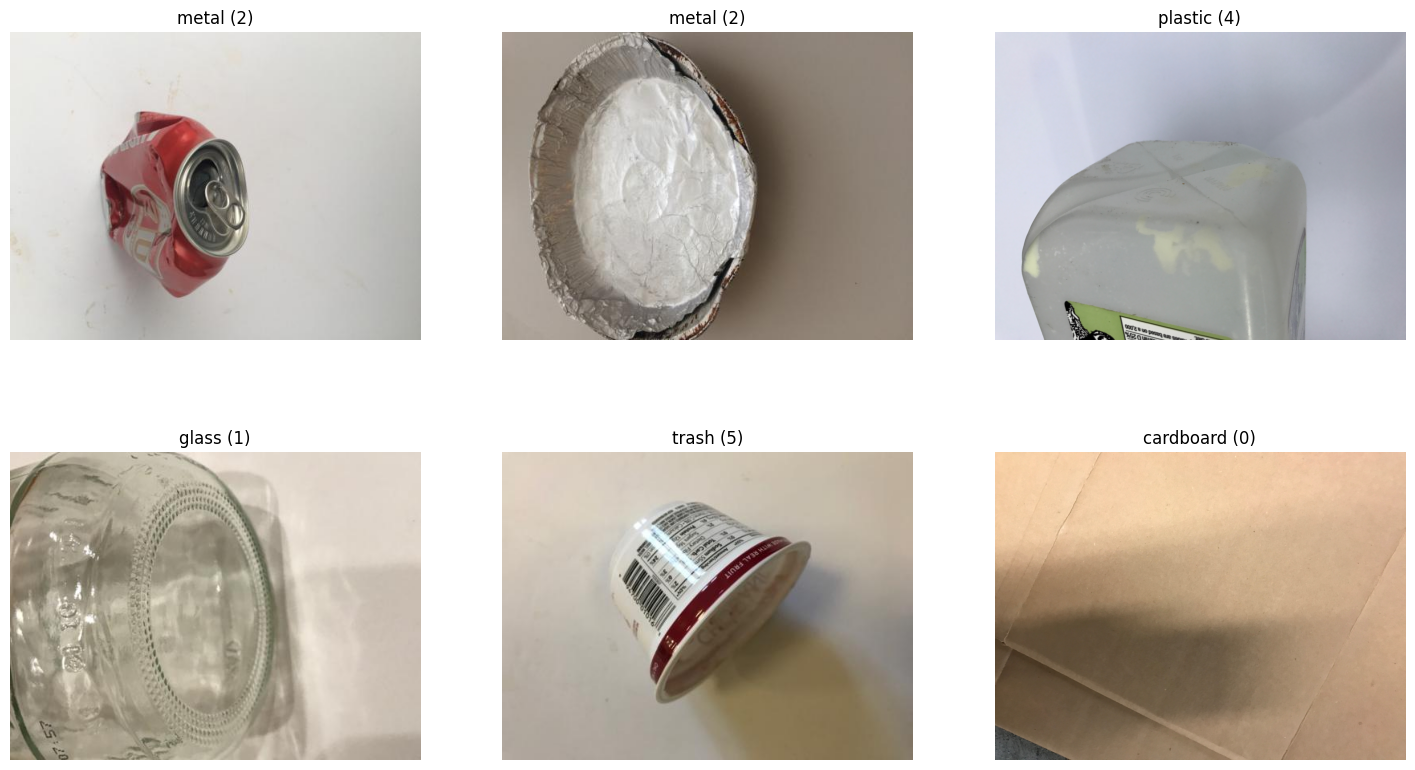

In [3]:
labels = {
    0: "cardboard",
    1: "glass",
    2: "metal",
    3: "paper",
    4: "plastic",
    5: "trash"
}

def display_random(dataset, num_images=4):
    rows = 2
    cols = np.ceil(num_images / rows).astype(int)

    plt.figure(figsize=(18, 10))
    indices = np.random.choice(range(len(dataset)), size=num_images, replace=False)

    for i, idx in enumerate(indices, 1):
        idx = int(idx)
        image = dataset[idx]['image']
        label = dataset[idx]['label']
        label_name = labels.get(label, "Unknown")

        plt.subplot(rows, cols, i)
        plt.imshow(image)
        plt.title(f"{label_name} ({label})")
        plt.axis('off')

plt.tight_layout()
plt.show()

display_random(dataset['train'], num_images=6)

In [4]:
class TrashnetDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        label = self.dataset[idx]['label']

        if self.transform:
            image = self.transform(image)

        return image, label
    
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Flip Horizontal
    transforms.RandomRotation(15),      # Rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Brighhtness and Contrast
    transforms.Resize((224, 224)),      # Resize
    transforms.ToTensor(),              # Tensorize
])

In [5]:
dataset_size = len(dataset['train'])

train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size 

train_data, val_data = random_split(dataset['train'], [train_size, val_size])

train_dataset = TrashnetDataset(train_data, transform=transform)
val_dataset = TrashnetDataset(val_data, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False
                        )


In [6]:
class TrashnetModel(torch.nn.Module):
    def __init__(self, num_classes):
        super(TrashnetModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) 
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  
        self.fc1 = nn.Linear(64 * 56 * 56, 128)  
        self.fc2 = nn.Linear(128, num_classes) 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = x.view(-1, 64 * 56 * 56)  
        x = F.relu(self.fc1(x))      
        x = self.fc2(x)            
        return x 

In [7]:
num_classes = len(set(dataset['train']['label'])) 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TrashnetModel(num_classes).to(device)

In [8]:
wandb.init(project="trashnet", config={
        'epochs': 10,
        'learning_rate': 0.001,
        'batch_size': train_loader.batch_size,
    }, name="GPU-CNN-Torch-1")

criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate) 

# Number of epochs
epochs = wandb.config.epochs

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in tqdm(range(epochs)):
    # --- Training Phase ---
    model.train() 
    running_train_loss = 0.0
    correct_train, total_train = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward prop
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward prop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Loss
        running_train_loss += loss.item()

        # training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # traning stats
    epoch_train_loss = running_train_loss / len(train_loader)
    epoch_train_accuracy = 100 * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # --- Validation Phase ---
    model.eval()  
    running_val_loss = 0.0
    correct_val, total_val = 0, 0

    with torch.no_grad():  
        for images, labels in val_loader: 
            images, labels = images.to(device), labels.to(device)

            # Forward prop
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Loss
            running_val_loss += loss.item()

            # Validation accuracy
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
    # validation stats
    epoch_val_loss = running_val_loss / len(val_loader)
    epoch_val_accuracy = 100 * correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)
    
    wandb.log({
        'epoch': epoch,
        'train_loss': epoch_train_loss,
        'train_accuracy': epoch_train_accuracy,
        'val_loss': epoch_val_loss,
        'val_accuracy': epoch_val_accuracy
    })
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.2f}%, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.2f}%")
    
wandb.finish()
            


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10, Train Loss: 1.8678, Train Acc: 29.66%, Val Loss: 1.4602, Val Acc: 39.07%


 10%|█         | 1/10 [26:15<3:56:22, 1575.82s/it]

Epoch 2/10, Train Loss: 1.3790, Train Acc: 43.48%, Val Loss: 1.4015, Val Acc: 42.83%


 20%|██        | 2/10 [52:13<3:28:38, 1564.86s/it]

Epoch 3/10, Train Loss: 1.3066, Train Acc: 47.37%, Val Loss: 1.2909, Val Acc: 49.65%


 30%|███       | 3/10 [1:17:58<3:01:32, 1556.11s/it]

Epoch 4/10, Train Loss: 1.2841, Train Acc: 49.69%, Val Loss: 1.2849, Val Acc: 48.27%


 40%|████      | 4/10 [1:43:11<2:33:54, 1539.10s/it]

Epoch 5/10, Train Loss: 1.2124, Train Acc: 52.58%, Val Loss: 1.2822, Val Acc: 51.14%


 50%|█████     | 5/10 [2:08:00<2:06:44, 1520.89s/it]

Epoch 6/10, Train Loss: 1.2047, Train Acc: 52.31%, Val Loss: 1.2375, Val Acc: 52.32%


 60%|██████    | 6/10 [2:33:05<1:41:02, 1515.57s/it]

Epoch 7/10, Train Loss: 1.1562, Train Acc: 55.23%, Val Loss: 1.2072, Val Acc: 55.39%


 70%|███████   | 7/10 [2:58:12<1:15:38, 1512.78s/it]

Epoch 8/10, Train Loss: 1.1104, Train Acc: 57.36%, Val Loss: 1.1900, Val Acc: 53.91%


 80%|████████  | 8/10 [3:23:27<50:27, 1513.51s/it]  

Epoch 9/10, Train Loss: 1.0981, Train Acc: 56.96%, Val Loss: 1.2128, Val Acc: 54.80%


 90%|█████████ | 9/10 [3:48:54<25:17, 1517.56s/it]

Epoch 10/10, Train Loss: 1.0638, Train Acc: 59.46%, Val Loss: 1.1855, Val Acc: 55.79%


100%|██████████| 10/10 [4:15:02<00:00, 1530.21s/it]


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▆▇█▇█
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▃▅▅▆▇█▇██
val_loss,█▇▄▄▃▂▂▁▂▁
epoch,9
train_accuracy,59.4608
train_loss,1.06383
val_accuracy,55.78635
val_loss,1.18551


In [9]:
epoch_val_loss = running_val_loss / len(val_loader)
epoch_val_accuracy = 100 * correct_val / total_val
val_losses.append(epoch_val_loss)
val_accuracies.append(epoch_val_accuracy)

print(f"Epoch [{epoch+1}/{epochs}]")
print(f"Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.2f}%")
print(f"Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.2f}%\n")

Epoch [10/10]
Train Loss: 1.0638, Train Accuracy: 59.46%
Validation Loss: 1.1855, Validation Accuracy: 55.79%



In [15]:
def save_model(version, model, config, metrics, base_dir="../models"):
    model_dir = os.path.join(base_dir, f"model_{version}")
    os.makedirs(model_dir, exist_ok=True)
    
    # Weights
    model_path = os.path.join(model_dir, f"model_{version}.pth")
    torch.save(model.state_dict(), model_path)
    
    # Configs
    config_path = os.path.join(model_dir, "config.json")
    with open(config_path, "w") as f:
        json.dump(config, f, indent=4)
    
    # Metrics
    metrics_path = os.path.join(model_dir, "metrics.json")
    with open(metrics_path, "w") as f:
        json.dump(metrics, f, indent=4)
    
    # README
    readme_path = os.path.join(base_dir, "README.md")
    with open(readme_path, "w") as f:
        f.write(f"# Model Version {version}\n")
        f.write(f"Created on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        f.write("## Metrics\n")
        for key, value in metrics.items():
            f.write(f"- *{key}*: {value}\n")
    
    
    print(f"Model version {version} saved successfully at {model_dir}.")

In [16]:
version = "1.0"
config = {
    "architecture": "Custom CNN",
    "input_size": (224, 224),
    "num_classes": num_classes,
    "transformations": [
        "RandomHorizontalFlip",
        "RandomRotation(15)",
        "ColorJitter(brightness=0.2, contrast=0.2)",
        "Resize(224x224)",
        "ToTensor"
    ],
    "optimizer": "Adam",
    "learning_rate": 0.001,
    "batch_size": train_loader.batch_size,
    "epochs": 10,
}

final_metrics = {
    "train_loss": train_losses[-1],
    "train_accuracy": train_accuracies[-1],
    "val_loss": val_losses[-1],
    "val_accuracy": val_accuracies[-1],
}

save_model(version, model, config, final_metrics)

Model version 1.0 saved successfully at ../models\model_1.0.
